# Shadow models audit for a PyTorch model trained on Purchase100

## Introduction

In this tutorial, we will see:
* How to create a Dataset object manually
* How to audit a PyTorch model
* How to use the ShadowMetric
* How to visualize the audit result

## Imports

In [1]:
from math import ceil
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch import nn, optim, Tensor

For now we install the library from the local source. A version will be pushed to pip soon.

In [2]:
import sys
!{sys.executable} -m pip install -e ../.
from privacy_meter.audit import Audit
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport
from privacy_meter.constants import InferenceGame
from privacy_meter.dataset import Dataset
from privacy_meter.hypothesis_test import threshold_func
from privacy_meter.information_source import InformationSource
from privacy_meter.information_source_signal import ModelLoss
from privacy_meter.metric import ShadowMetric
from privacy_meter.model import PytorchModel

Obtaining file:///home/victor/ml_privacy_meter
  Preparing metadata (setup.py) ... done
  Attempting uninstall: privacy-meter
    Found existing installation: privacy-meter 1.0
    Uninstalling privacy-meter-1.0:
      Successfully uninstalled privacy-meter-1.0
  Running setup.py develop for privacy-meter


## Settings

Setting seed for reproducibility:

In [3]:
np.random.seed(1234)

Hyper parameters:

In [4]:
n_shadow_models = 10  # Number of shadow models to be trained
epochs = 20           # Number of epochs for each model
batch_size = 32       # Batch size for the trainings

## Dataset creation

Let's download the Purchase100 dataset (presented in https://www.cs.cornell.edu/~shmat/shmat_oak17.pdf on page 7) and extract it:

In [5]:
!wget https://github.com/privacytrustlab/datasets/raw/master/dataset_purchase.tgz
!tar -xvzf dataset_purchase.tgz
!rm dataset_purchase.tgz

--2022-05-06 11:39:55--  https://github.com/privacytrustlab/datasets/raw/master/dataset_purchase.tgz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/privacytrustlab/datasets/master/dataset_purchase.tgz [following]
--2022-05-06 11:39:55--  https://raw.githubusercontent.com/privacytrustlab/datasets/master/dataset_purchase.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22045876 (21M) [application/octet-stream]
Saving to: ‘dataset_purchase.tgz’

dataset_purchase.tg 100%[===================>]  21.02M  11.1MB/s    in 1.9s    

2022-05-06 11:39:57 (11.1 MB/s) - ‘dataset_purchase.tgz’ saved [22

We need to read the file and preprocess the dataset:

In [6]:
def preprocess_purchase100():
    """
    Cf. https://www.cs.cornell.edu/~shmat/shmat_oak17.pdf page 7
    Returns:

    """
    # Read raw dataset
    dataset_path = "dataset_purchase"
    with open(dataset_path, "r") as f:
        purchase_dataset = f.readlines()
    # Separate features and labels into different arrays
    x, y = [], []
    for datapoint in purchase_dataset:
        split = datapoint.rstrip().split(",")
        label = int(split[0]) - 1  # The first value is the label
        features = np.array(split[1:], dtype=np.float32)  # The next values are the features
        x.append(features)
        y.append(label)
    # Make sure the datatype is correct
    x = np.array(x, dtype=np.float32)
    # Convert labels into one hot vectors
    y = OneHotEncoder(sparse=False).fit_transform(np.expand_dims(y, axis=1))
    # Split data into train, test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1234)
    return x_train, y_train, x_test, y_test

In [7]:
x_train, y_train, x_test, y_test = preprocess_purchase100()

Then, we wrap the dataset into a Dataset object:
* `data_dict` contains the actual dataset, in the form of a 2D dictionary. The first key corresponds to the split name (here we have two: "train" and "test"), and the second key to the feature name (here we also have two: "x" and "y").
* `default_input` contains the name of the feature that should be used as the models input (here "x").
* `default_output` contains the name of the feature that should be used as the label / models output (here "y").

In [8]:
dataset = Dataset(
    data_dict={'train': {'x': x_train, 'y': y_train}, 'test': {'x': x_test, 'y': y_test}},
    default_input='x',
    default_output='y'
)

Finally, we use the built-in `Dataset.subdivide()` function, to split the two splits ("train" and "test") into multiple sub-datasets (one per model). The resulting sub-splits are included in the parent object ("train000", "train001", etc.) and are returned as a list of individual Dataset objects.

In [9]:
datasets_list = dataset.subdivide(
    num_splits=n_shadow_models + 1,
    delete_original=True,
    in_place=True,
    return_results=True,
    method='hybrid',
    split_size=10000
)

In [10]:
for i, d in enumerate(datasets_list):
    print(i)
    print(d)

0
================ DATASET OBJECT ================
Splits            = ['train', 'test']
Features          = ['x', 'y']
Default features  = x --> y
1
================ DATASET OBJECT ================
Splits            = ['train', 'test']
Features          = ['x', 'y']
Default features  = x --> y
2
================ DATASET OBJECT ================
Splits            = ['train', 'test']
Features          = ['x', 'y']
Default features  = x --> y
3
================ DATASET OBJECT ================
Splits            = ['train', 'test']
Features          = ['x', 'y']
Default features  = x --> y
4
================ DATASET OBJECT ================
Splits            = ['train', 'test']
Features          = ['x', 'y']
Default features  = x --> y
5
================ DATASET OBJECT ================
Splits            = ['train', 'test']
Features          = ['x', 'y']
Default features  = x --> y
6
================ DATASET OBJECT ================
Splits            = ['train', 'test']
Features          = ['x

Let's now define the pytorch models to be used: one target model, and `n_shadow_models` shadow models.

In [11]:
torch_models = [
    nn.Sequential(
        nn.Linear(in_features=600, out_features=128),
        nn.Tanh(),
        nn.Linear(in_features=128, out_features=100),
        nn.Softmax(dim=1)
    )
    for _ in range(n_shadow_models + 1)
]

We define the loss:

In [12]:
criterion = nn.CrossEntropyLoss(reduction='sum')

And we train each model on its split of the dataset:

In [13]:
for k, model in enumerate(torch_models):
    optimizer = optim.Adam(model.parameters())
    x = dataset.get_feature(split_name=f'train{k:03d}', feature_name='<default_input>')
    y = dataset.get_feature(split_name=f'train{k:03d}', feature_name='<default_output>')
    n_samples = x.shape[0]
    n_batches = ceil(n_samples / batch_size)
    x = np.array_split(x, n_batches)
    y = np.array_split(y, n_batches)
    for epoch in range(epochs):
        epoch_loss, acc = 0.0, 0.0
        for b in range(n_batches):
            optimizer.zero_grad()
            y_pred = model(Tensor(x[b]))
            loss = criterion(Tensor(y[b]), y_pred)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            acc += torch.sum(y_pred.argmax(axis=1) == Tensor(y[b]).argmax(axis=1))
        acc /= n_samples
        epoch_loss /= n_samples
        print(f'model #{k:02d}, epoch #{epoch:03d}:\ttrain_acc = {acc:.3f}\ttrain_loss = {epoch_loss:.3e}')

model #00, epoch #000:	train_acc = 0.110	train_loss = 4.532e+00
model #00, epoch #001:	train_acc = 0.282	train_loss = 4.380e+00
model #00, epoch #002:	train_acc = 0.360	train_loss = 4.302e+00
model #00, epoch #003:	train_acc = 0.402	train_loss = 4.252e+00
model #00, epoch #004:	train_acc = 0.433	train_loss = 4.216e+00
model #00, epoch #005:	train_acc = 0.451	train_loss = 4.191e+00
model #00, epoch #006:	train_acc = 0.460	train_loss = 4.176e+00
model #00, epoch #007:	train_acc = 0.463	train_loss = 4.168e+00
model #00, epoch #008:	train_acc = 0.481	train_loss = 4.152e+00
model #00, epoch #009:	train_acc = 0.491	train_loss = 4.140e+00
model #00, epoch #010:	train_acc = 0.508	train_loss = 4.125e+00
model #00, epoch #011:	train_acc = 0.517	train_loss = 4.112e+00
model #00, epoch #012:	train_acc = 0.521	train_loss = 4.107e+00
model #00, epoch #013:	train_acc = 0.530	train_loss = 4.098e+00
model #00, epoch #014:	train_acc = 0.533	train_loss = 4.093e+00
model #00, epoch #015:	train_acc = 0.533

Now that the models are all train, we can wrap each of them in a `PytorchModel` object:

In [14]:
models = [
    PytorchModel(
        model_obj=model,
        loss_fn=criterion
    )
    for model in torch_models
]

## Information Sources

We can now define two InformationSource objects. Basically, an information source is an abstraction representing a set of models, and their corresponding dataset. Note that we could use the same `dataset` variable for the two InformationSource objects (each one would be queried on different splits of the dataset), but we also stored the sub-splits in different Dataset objects, so let's use them.

In [15]:
target_info_source = InformationSource(
    models=[models[0]],
    datasets=[datasets_list[0]]
)

reference_info_source = InformationSource(
    models=models[1:],
    datasets=datasets_list[1:]
)

## Metric and Audit

We now create a Metric object, which is an abstraction representing an algorithm used to measure something on an InformationSource, such as membership information leakage. In this case, we use the ShadowMetric to measure the membership information leakage of `target_info_source` in a black-box setting, using shadow models.

In [16]:
metric = ShadowMetric(
    target_info_source=target_info_source,
    reference_info_source=reference_info_source,
    signals=[ModelLoss()],
    hypothesis_test_func=threshold_func,
    unique_dataset=False,
    reweight_samples=True
)

Finally, the Audit object is a wrapper to actually run the audit, and display the results. More visualization options will be added soon.

In [17]:
audit = Audit(
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    metrics=metric,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source
)
audit.prepare()
result = audit.run()[0]

Results are stored in: ['/home/victor/ml_privacy_meter/docs/log_2022-05-06_11-42-22-000']


In [18]:
print(result)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.56685
ROC AUC Score     = 0.58509139
FPR               = 0.4053
TN, FP, FN, TP    = (5947, 4053, 4610, 5390)


## Result visualization

Several visualization tools are built in `privacy_tool`, such as ROC curves, signal values histogram, or confusion matrix.

In [19]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../privacy_meter/report_files'

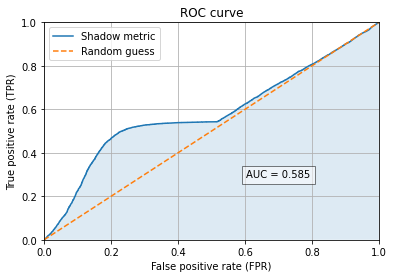

<Figure size 432x288 with 0 Axes>

In [20]:
ROCCurveReport.generate_report(
    metric_result=result,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

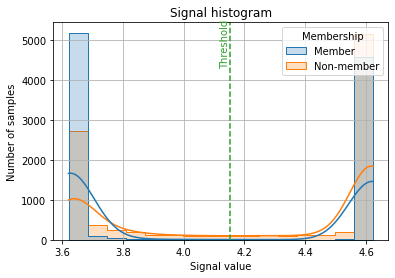

<Figure size 432x288 with 0 Axes>

In [21]:
SignalHistogramReport.generate_report(
    metric_result=result,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)